In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from keras.models import Sequential
from keras import layers
from keras.backend import clear_session
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [22]:
filepath_dict = {'yelp':   '../datasets/comments_for_text_classification/yelp_labelled.txt',
                 'amazon': '../datasets/comments_for_text_classification/amazon_cells_labelled.txt',
                 'imdb':   '../datasets/comments_for_text_classification/imdb_labelled.txt'}
df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t')
    df['source'] = source  # Add another column filled with the source name
    df_list.append(df)

df = pd.concat(df_list)
df

,sentence,label,source
0,Wow... Loved this place.,1,yelp
1,Crust is not good.,0,yelp
2,Not tasty and the texture was just nasty.,0,yelp
3,Stopped by during the late May bank holiday of...,1,yelp
4,The selection on the menu was great and so wer...,1,yelp
...,...,...,...
743,I just got bored watching Jessice Lange take h...,0,imdb
744,"Unfortunately, any virtue in this film's produ...",0,imdb
745,"In a word, it is embarrassing.",0,imdb
746,Exceptionally bad!,0,imdb


In [23]:
#Training a model with logistic regression

for source in df["source"].unique():
    source_data = df[df["source"] == source]
    sentences = source_data["sentence"].values
    y = source_data["label"].values
    sentence_train, sentence_test, y_train, y_test = train_test_split(sentences, y, test_size = 0.25, random_state = 42)
    vectorizer = CountVectorizer()
    vectorizer.fit(sentence_train)
    X_train = vectorizer.transform(sentence_train)
    X_test = vectorizer.transform(sentence_test)
    classifier = LogisticRegression()
    classifier.fit(X_train, y_train)
    score = classifier.score(X_test, y_test)
    print(f"{source} data accuracy: {score}")

yelp data accuracy: 0.816
amazon data accuracy: 0.844
imdb data accuracy: 0.7272727272727273


Training accuracy : 0.998217
Testing accuracy : 0.764706


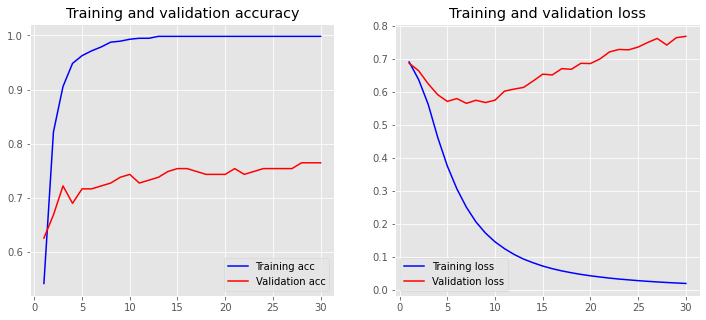

In [17]:
input_shape = X_train.shape[1]

model = Sequential()
model.add(layers.Dense(10, input_dim= input_shape, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

model.compile(optimizer="adam", loss= "binary_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, y_train,
                    epochs = 30,
                    batch_size= 10,
                    validation_data= (X_test, y_test),
                    verbose=0)

loss, accuracy = model.evaluate(X_train, y_train, verbose=0)
print("Training accuracy : {:4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Testing accuracy : {:4f}".format(accuracy))


plt.style.use("ggplot")
def plot_history(history):
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(accuracy) + 1)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy, 'b', label='Training acc')
    plt.plot(x, val_accuracy, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
plot_history(history)
clear_session()

Training Accuracy: 1.0000
Testing Accuracy:  0.7968


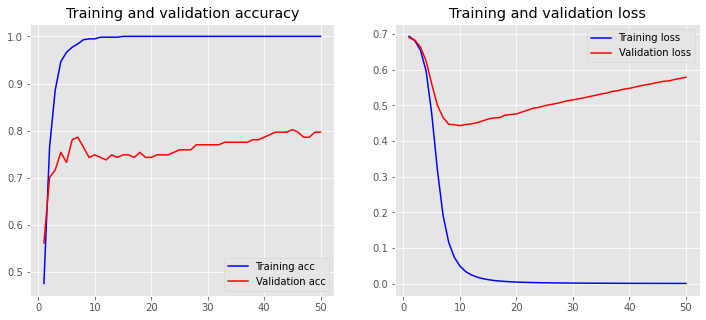

In [36]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentence_train)

X_train = tokenizer.texts_to_sequences(sentence_train)
X_test = tokenizer.texts_to_sequences(sentence_test)

vocabulary_size = len(tokenizer.word_index) + 1
maxlen = 100
X_train = pad_sequences(X_train, padding="post", maxlen=maxlen)
X_test = pad_sequences(X_test, padding="post", maxlen=maxlen)

embedding_dim = 50
model = Sequential()
model.add(layers.Embedding(input_dim=vocabulary_size,
                           output_dim=embedding_dim,
                           input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)
clear_session()